# Neural Network Classifier
This notebook implements a deep learning model to predict depression risk in students and working professionals based on lifestyle, academic, and psychological factors.

In [108]:
# Necessary imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -q sweetviz
import sweetviz as sv 

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import accuracy_score


import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import Image, display
from tqdm import tqdm
import imageio
import os

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cpu")

In [109]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
original = pd.read_csv('final_depression_dataset_1.csv')
train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [110]:
# Set targets and columns
target = 'Depression'

numerical_columns = [
    "Age", "Academic Pressure", "Work Pressure", "CGPA",
    "Study Satisfaction", "Job Satisfaction", "Work/Study Hours",
    "Financial Stress"
]

one_hot_columns = [
    "Gender", "Working Professional or Student", "City", "Family History of Mental Illness", "Sleep Duration"
]

label_columns = [
    "Degree", "Profession", "Dietary Habits", "Have you ever had suicidal thoughts ?"
]

In [111]:
class DataPreprocessor:
    """
    Preprocessing data methods
    
    """

    def __init__(self, numerical_columns, one_hot_columns, label_columns):
        self.numerical_columns = numerical_columns
        self.one_hot_columns = one_hot_columns
        self.label_columns = label_columns

        self.scaler = StandardScaler()
        self.one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        
        self.label_encoders = {
            col: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) for col in self.label_columns
        }

        self.one_hot_feature_names = None

    def fit(self, df):
        self.scaler.fit(df[self.numerical_columns])

        self.one_hot_encoder.fit(df[self.one_hot_columns])
        self.one_hot_feature_names = self.one_hot_encoder.get_feature_names_out(self.one_hot_columns)

        for col in self.label_columns:
            self.label_encoders[col].fit(df[[col]])

    def transform(self, df):
        df_scaled = df.copy()

        df_scaled[self.numerical_columns] = self.scaler.transform(df[self.numerical_columns])

        encoded_columns = self.one_hot_encoder.transform(df[self.one_hot_columns])
        encoded_df = pd.DataFrame(encoded_columns, columns=self.one_hot_feature_names, index=df.index)

        for col in self.label_columns:
            df_scaled[col] = self.label_encoders[col].transform(df[[col]])

        df_final = pd.concat([df_scaled.drop(self.one_hot_columns, axis=1), encoded_df], axis=1)

        return df_final

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

In [112]:
train[one_hot_columns + label_columns] = train[one_hot_columns + label_columns].fillna('None')
train[numerical_columns] = train[numerical_columns].fillna(-1)

preprocessor = DataPreprocessor(numerical_columns, one_hot_columns, label_columns)

preprocessor.fit(train)

train = preprocessor.transform(train)
test = preprocessor.transform(test)
train

,id,Name,Age,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Dietary Habits,...,Sleep Duration_Indore,Sleep Duration_Less than 5 hours,Sleep Duration_Moderate,Sleep Duration_More than 8 hours,Sleep Duration_No,Sleep Duration_Pune,Sleep Duration_Sleep_Duration,Sleep Duration_Unhealthy,Sleep Duration_Work_Study_Hours,Sleep Duration_than 5 hours
0,0,Aaradhya,0.695360,10.0,-0.466066,1.375480,-0.488670,-0.464082,-0.091653,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Vivan,-1.161867,56.0,-0.466066,0.883269,-0.488670,-0.464082,0.401054,21.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Yuvraj,-0.596624,43.0,2.938771,-1.577787,2.349132,1.315885,-1.569774,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Yuvraj,-1.484863,56.0,-0.466066,1.375480,-0.488670,-0.464082,-0.584360,15.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Rhea,-0.838871,9.0,-0.466066,-0.593365,-0.488670,-0.464082,-0.584360,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695,Vidya,-1.807859,43.0,-0.466066,1.375480,-0.488670,-0.464082,0.893761,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140696,140696,Lata,0.049368,15.0,-0.466066,1.375480,-0.488670,-0.464082,0.893761,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140697,140697,Aanchal,-1.323365,38.0,-0.466066,0.391058,-0.488670,-0.464082,-0.584360,15.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
140698,140698,Prachi,0.695360,48.0,-0.466066,1.375480,-0.488670,-0.464082,-0.091653,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
# Implement neural network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        
        self.fc3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        out = self.fc1(x)
        out = self.batch_norm1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.batch_norm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)
        out = self.batch_norm3(out)
        out = self.relu3(out)
        
        out = self.fc4(out)

        return out

Using device: cpu


In [116]:
X = train.drop(target, axis=1).apply(pd.to_numeric, errors='coerce').fillna(0).values
y = train[target].values

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

X_test = test.drop(['id', 'Name'], axis=1).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
model = BinaryClassificationModel(input_size=X.shape[1])
model = model.to(device)

Epoch [10/100], Loss: 0.1627
Epoch [20/100], Loss: 0.1593
Epoch [30/100], Loss: 0.1576
Epoch [40/100], Loss: 0.1562
Epoch [50/100], Loss: 0.1554
Epoch [60/100], Loss: 0.1543
Epoch [70/100], Loss: 0.1541
Epoch [80/100], Loss: 0.1532
Epoch [90/100], Loss: 0.1525
Epoch [100/100], Loss: 0.1518


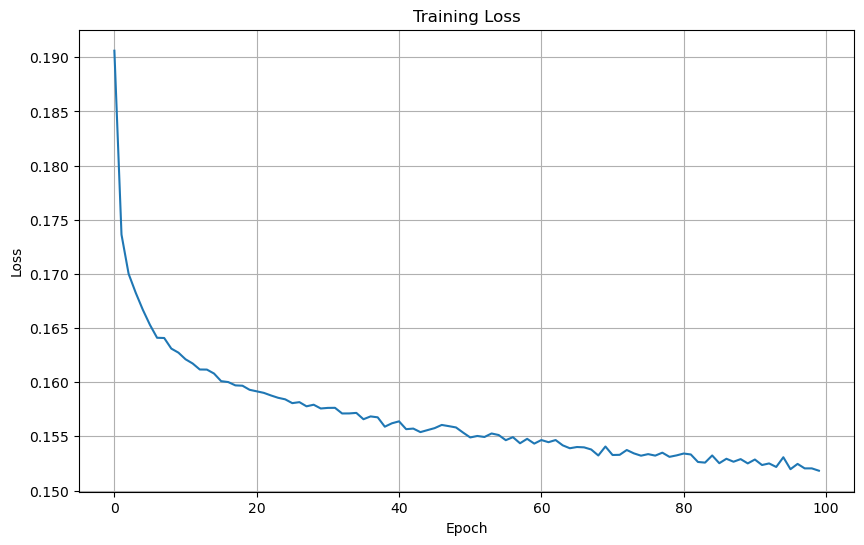

In [ ]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training parameters
epochs = 100
batch_size = 32

# Convert y to float and reshape for BCE loss
y = y.float().view(-1, 1)

# Training loop
model.train()
train_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for i in range(0, len(X), batch_size):
        end_idx = min(i + batch_size, len(X))
        batch_X = X[i:end_idx]
        batch_y = y[i:end_idx]
        
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Training Accuracy: 0.9399
Training AUC-ROC: 0.9763


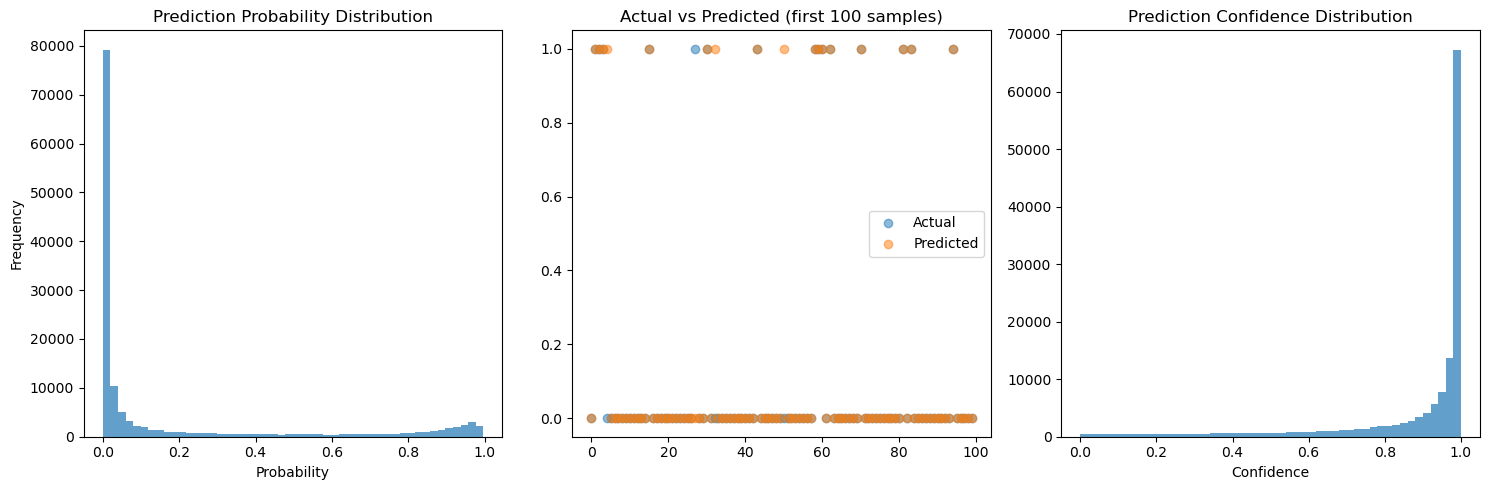

In [ ]:
# Evaluate on training data
model.eval()
with torch.no_grad():
    train_outputs = model(X)
    train_predictions = torch.sigmoid(train_outputs)  
    train_pred_classes = (train_predictions > 0.5).float()
    
    # Calculate training accuracy
    train_accuracy = (train_pred_classes == y).float().mean()
    print(f'Training Accuracy: {train_accuracy.item():.4f}')
    
    # Calculate AUC-ROC
    try:
        train_auc = roc_auc_score(y.cpu().numpy(), train_predictions.cpu().numpy())
        print(f'Training AUC-ROC: {train_auc:.4f}')
    except:
        print("Could not calculate AUC-ROC")

plt.figure(figsize=(15, 5))

# Prediction distribution
plt.subplot(1, 3, 1)
plt.hist(train_predictions.cpu().numpy(), bins=50, alpha=0.7)
plt.title('Prediction Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Actual vs Predicted
plt.subplot(1, 3, 2)
plt.scatter(range(len(y[:100])), y[:100].cpu().numpy(), alpha=0.5, label='Actual')
plt.scatter(range(len(train_pred_classes[:100])), train_pred_classes[:100].cpu().numpy(), alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted (first 100 samples)')
plt.legend()

# Confidence scores
plt.subplot(1, 3, 3)
confidence = torch.abs(train_predictions - 0.5) * 2  
plt.hist(confidence.cpu().numpy(), bins=50, alpha=0.7)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence')

plt.tight_layout()
plt.show()

In [104]:
# Make predictions on test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = torch.sigmoid(test_outputs)
    test_pred_classes = (test_predictions > 0.5).float()

# Convert to numpy
test_pred_proba = test_predictions.cpu().numpy().flatten()
test_pred_binary = test_pred_classes.cpu().numpy().flatten()

print(f"Test predictions - Mean probability: {test_pred_proba.mean():.4f}")
print(f"Positive predictions: {test_pred_binary.sum()} out of {len(test_pred_binary)}")
print(f"Positive rate: {test_pred_binary.mean():.4f}")

Test predictions - Mean probability: 0.2220
Positive predictions: 19212.0 out of 93800
Positive rate: 0.2048


In [ ]:
submission = pd.DataFrame({
    'id': test['id'],
    'Name': test['Name'],
    'Depression': test_pred_binary,
    'Depression_Probability': test_pred_proba
})

submission_file = 'nn.csv'
submission.to_csv(submission_file, index=False)
print(f"Submission file saved as: {submission_file}")

print("\nFirst 10 rows of submission:")
print(submission.head(10))
print(f"\nPrediction Statistics:")
print(f"Total predictions: {len(submission)}")
print(f"Depression cases predicted: {submission['Depression'].sum()}")
print(f"Non-depression cases predicted: {len(submission) - submission['Depression'].sum()}")
print(f"Depression rate: {submission['Depression'].mean():.4f}")

Submission file saved as: nn.csv

First 10 rows of submission:
       id     Name  Depression  Depression_Probability
0  140700   Shivam         0.0                0.003700
1  140701    Sanya         0.0                0.001230
2  140702     Yash         0.0                0.074081
3  140703   Nalini         1.0                0.997368
4  140704  Shaurya         0.0                0.019697
5  140705   Kartik         0.0                0.009274
6  140706   Armaan         0.0                0.008832
7  140707   Ritika         0.0                0.049860
8  140708    Navya         0.0                0.179953
9  140709   Harsha         1.0                0.950785

Prediction Statistics:
Total predictions: 93800
Depression cases predicted: 19212.0
Non-depression cases predicted: 74588.0
Depression rate: 0.2048



Confidence Analysis:
Confidence_Level
Low       69898
Medium     8536
High      15366
Name: count, dtype: int64


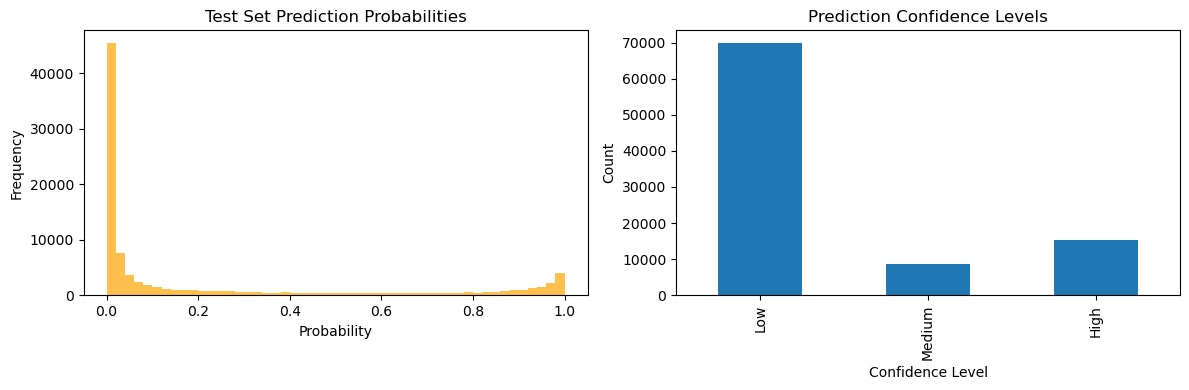

In [106]:
# Analyze prediction confidence
confidence_analysis = pd.DataFrame({
    'Probability': test_pred_proba,
    'Prediction': test_pred_binary
})

# Create confidence bins
confidence_analysis['Confidence_Level'] = pd.cut(test_pred_proba, 
                                               bins=[0, 0.3, 0.7, 1.0], 
                                               labels=['Low', 'Medium', 'High'])

print("\nConfidence Analysis:")
print(confidence_analysis['Confidence_Level'].value_counts().sort_index())

# Plot test prediction distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(test_pred_proba, bins=50, alpha=0.7, color='orange')
plt.title('Test Set Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
confidence_analysis['Confidence_Level'].value_counts().sort_index().plot(kind='bar')
plt.title('Prediction Confidence Levels')
plt.xlabel('Confidence Level')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_size': X.shape[1],
    'preprocessor_info': {
        'numerical_columns': numerical_columns,
        'one_hot_columns': one_hot_columns,
        'label_columns': label_columns
    }
}, 'depression_model.pth')

print("Model saved as 'depression_model.pth'")

Model saved as 'depression_model.pth'
